# Clusterings results analysis - for Romina's congress

We trained a FCM model with k=10 on 13 samples agreed and coordinated with Talia. After training, we load the model, and make prediction on a new sample (emc_0119). Then we show a single slide

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.io
import pandas as pd

## Load validation matrix, rescale and make cluster predictions

In [2]:
out_dir = "/home/labs/bioservices/eligol/01_projects/06_pregnancy_MRI/data/inference_on_emc_019/GGM/"
os.makedirs(out_dir, exist_ok=True)

# load trained model
with open("/home/labs/bioservices/eligol/01_projects/06_pregnancy_MRI/data/BGM_4channels_labels/13_samples_10_means/BGM_K10_13_samples_model.pkl", "rb") as f:
    fcm10_model = pickle.load(f)

/home/labs/bioservices/eligol/.venvs/MLbio/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.0.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(360, 320, 260, 4)
max pixel: 3.0
min pixel: 0.0
bit depth: 22.347691108157253


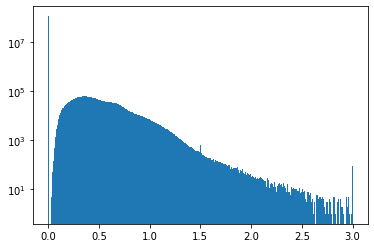

In [3]:
# load validation sample 
val_mat = scipy.io.loadmat("/home/labs/neeman/Collaboration/Placenta_MRI_2021/data/raw_data_dropbox/4channels/emc_0019_cass.mat")
val_mat = val_mat['map_mat'] # get pixel data

# some info about the validation matrix
print(val_mat.shape)
print("max pixel:", val_mat.max())
print("min pixel:", val_mat.min())
print("bit depth:", np.log2(len(np.unique(val_mat))))

plt.hist(val_mat.ravel(), bins=512, log=True)
plt.show()

## standard scale the val sample

/home/labs/bioservices/eligol/.venvs/MLbio/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


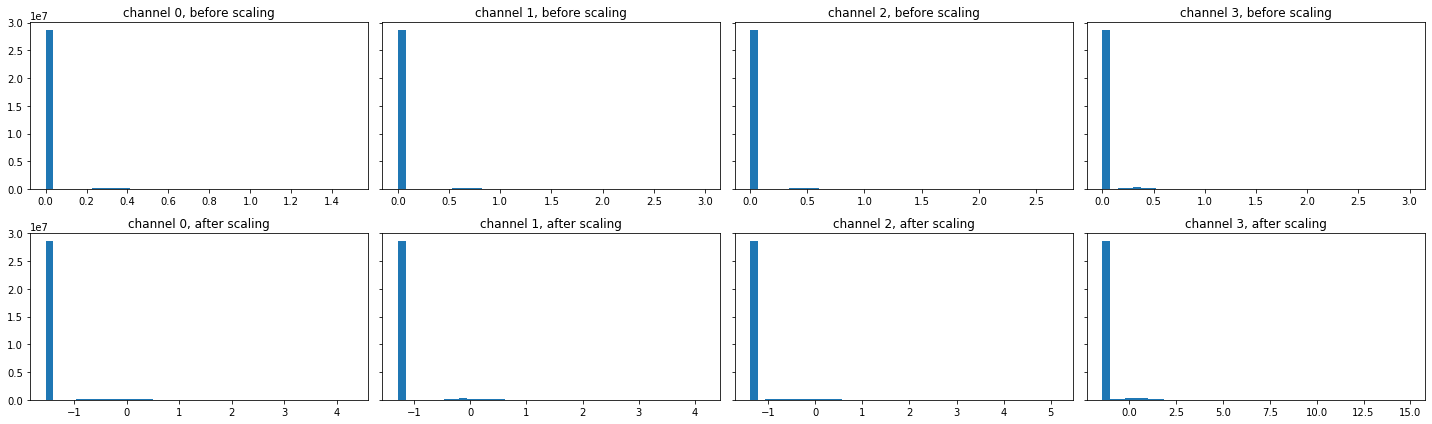

In [4]:

from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots(2, val_mat.shape[-1], figsize=(20,6), sharey=True)

for i in range(val_mat.shape[-1]):
    ax[0][i].hist(val_mat[:,:,:,i].ravel(), bins=40)
    ax[0][i].set_title("channel {}, before scaling".format(i))

# load sclaer tat was fitted on training set
with open("/home/labs/bioservices/eligol/01_projects/06_pregnancy_MRI/code/13_samlple_4ch_std_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
# transform val data
val_mat_scaled = scaler.transform(val_mat.reshape(-1, val_mat.shape[-1])).reshape(val_mat.shape)

for i in range(val_mat_scaled.shape[-1]):
    ax[1][i].hist(val_mat_scaled[:,:,:,i].ravel(), bins=40)
    ax[1][i].set_title("channel {}, after scaling".format(i))

plt.tight_layout()
plt.show()

## Reshape the validation sample 

In [6]:
# reshape the validation array to a vector
print("shpae before:", val_mat_scaled.shape)
vec_to_cluster = np.reshape(val_mat_scaled, newshape=(val_mat_scaled.shape[0] * val_mat_scaled.shape[1] * val_mat_scaled.shape[2] ,val_mat_scaled.shape[3]))
print("shpae after:", vec_to_cluster.shape)

val_mat_pred = fcm10_model.predict(vec_to_cluster)
# val_mat_pred = np.random.randint(0, 10,(vec_to_cluster.shape[0]))
                
# return to original shape
val_mat_pred = np.reshape(val_mat_pred.astype('int8'), newshape=(val_mat_scaled.shape[0], val_mat_scaled.shape[1], val_mat_scaled.shape[2]))
val_mat_pred.shape

shpae before: (360, 320, 260, 4)
shpae after: (29952000, 4)


(360, 320, 260)

### plots of predicted clusters validation sample

clusters observed: [0 1 2 3 4 5 6 7 8 9]


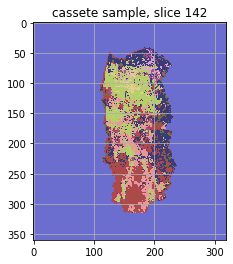

In [7]:
plt.imshow(val_mat_pred[:, :, 142], cmap='tab20b')
plt.title("cassete sample, slice 142")
print("clusters observed:", np.unique(val_mat_pred[:, :, 142]))
plt.grid(None) 
plt.savefig(os.path.join(out_dir, "cassete_clusters_slice_142.png"),dpi=400)
plt.show()

## barplot for control samples

In [8]:
# load the masked matrix of the samples
all_snames = ['emc_0117', 'emc_0201', 'mmc_0122', 'hmo_0252', 'mmc_0178', 'hymc_0085', 'mmc_0255', 'mmc_0084', 'mmc_0129', 'mmc_0123', 'mmc_0086', 'mmc_0228', 'mmc_0128']
clusters_path = '/home/labs/bioservices/eligol/01_projects/06_pregnancy_MRI/data/13_samples_4channels_labels/FCM_10_means/labels_mask_4ch.npy'
clusters_mat = np.load(clusters_path)

clusters_mat_ctrl = clusters_mat[:9]
clusters_mat_GD = clusters_mat[9:]

In [9]:
# create a data frame with the data
df_all_samples = pd.DataFrame()
for i in range(clusters_mat.shape[0]):
    labels, label_counts = np.unique(clusters_mat[i,:,:,:], return_counts=True)
    df_temp = pd.DataFrame(np.array([labels, label_counts]).T, columns = ['label', 'pixel_counts'])
    df_temp['sname'] = all_snames[i]
    df_temp['class'] = 'control' if i < 9 else 'GD'
    df_all_samples = pd.concat([df_all_samples, df_temp], ignore_index=True)
df_all_samples

,label,pixel_counts,sname,class
0,0,857575,emc_0117,control
1,1,1050181,emc_0117,control
2,2,247870,emc_0117,control
3,3,378107,emc_0117,control
4,4,504167,emc_0117,control
...,...,...,...,...
125,5,438344,mmc_0128,GD
126,6,442538,mmc_0128,GD
127,7,417555,mmc_0128,GD
128,8,720835,mmc_0128,GD


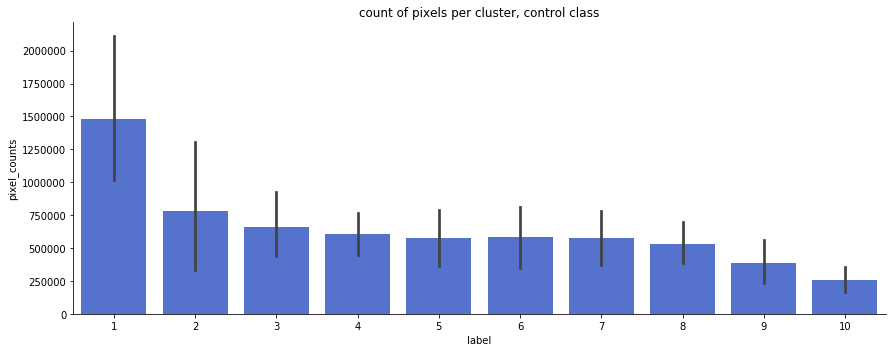

In [10]:
s = sns.catplot(x='label', y='pixel_counts', data=df_all_samples[df_all_samples['class'] == 'control']
                , order=[1, 6,0,8,7,2,3,4,5,9],kind="bar", color='royalblue', aspect=2.5)
s.set_xticklabels([str(k + 1) for k in labels])
plt.title("count of pixels per cluster, control class")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'pixel_counts_per_cluster_control.png'))
plt.show()

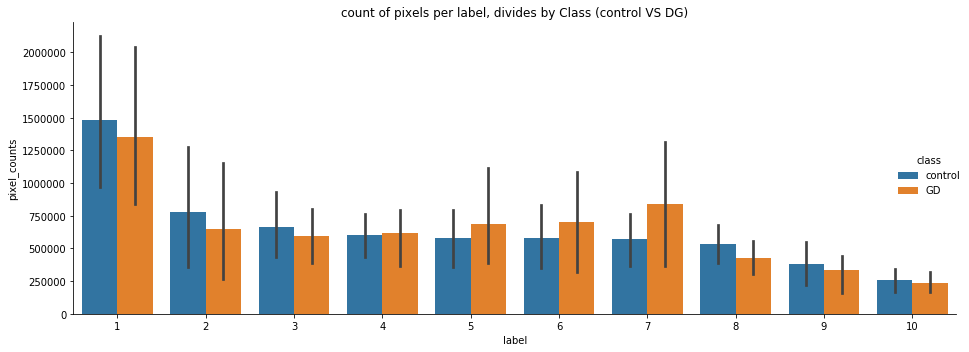

In [11]:
s = sns.catplot(x='label', y='pixel_counts', data=df_all_samples, hue="class", kind="bar", order=[1,6,0,8,7,2,3,4,5,9], aspect=2.5)
s.set_xticklabels([str(k+1) for k in labels])
plt.title("count of pixels per label, divides by Class (control VS DG)")

plt.tight_layout()
plt.savefig(os.path.join(out_dir,'pixel_counts_per_label_ctrl_DG.png'))
plt.show()